### IBM AutoAI-SDK Auto-Generated Notebook v1.14.2

**Note:** Notebook code generated using AutoAI will execute successfully. If code is modified or reordered,   
there is no guarantee it will successfully execute. This pipeline is optimized for the original dataset.  
The pipeline may fail or produce sub-optimium results if used with different data. For different data,  
please consider returning to AutoAI Experiments to generate a new pipeline. Please read our documentation   
for more information:   
<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/autoai-notebook.html">Cloud Platform</a>  


Before modifying the pipeline or trying to re-fit the pipeline, consider:   
The notebook converts dataframes to numpy arrays before fitting the pipeline   
(a current restriction of the preprocessor pipeline). The known_values_list is passed by reference   
and populated with categorical values during fit of the preprocessing pipeline. Delete its members before re-fitting.

<a id="content"></a>
## Notebook content

This notebook contains steps and code to demonstrate AutoAI pipeline. This notebook introduces commands for getting data,  
pipeline model, model inspection and testing.

Some familiarity with Python is helpful. This notebook uses Python 3.

## Notebook goals

-  inspection of trained pipeline via graphical vizualization and source code preview
-  pipeline evaluation
-  pipeline deployment and webservice scoring.

## Contents

This notebook contains the following parts:

1.	[Setup](#setup)         
    a.  [AutoAI experiment metadata](#variables_definition)      
2.	[Pipeline inspection](#inspection)      
    a.  [Get historical optimizer instance](#get_hist_and_train)      
    b.  [Get pipeline model](#get_pipeline)      
    c.  [Preview pipeline model as python code](#preview_model_to_python_code)      
    d.  [Visualize pipeline model](#visualize_pipeline)      
    e.  [Read training data](#train_read)        
    f.  [Test pipeline model locally](#test_model)       
3.	[Pipeline refinery and testing (optional)](#refinery)  
    a.  [Pipeline definition source code](#pipeline_definition)      
    b.  [Lale library](#lale_library)      
4.	[Deploy and score](#scoring)       
    a.  [Insert WML credentials](#wml_credentials)   
    b.  [Create deployment](#deployment)      
    c.  [Score webservice](#online_scoring)        
    d.  [Delete deployment](#delete_deployment)       
5.  [Authors](#authors)      

<a id="setup"></a>
# Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:
 - `ibm_watson_machine_learning` installation
 - `autoai-libs` installation/upgrade
 - `lightgbm` or `xgboost` installation/downgrade if they are needed.

In [1]:
!pip install -U ibm-watson-machine-learning

     |████████████████████████████████| 1.7 MB 14.1 MB/s eta 0:00:01
  Attempting uninstall: ibm-watson-machine-learning
    Found existing installation: ibm-watson-machine-learning 1.0.44
    Uninstalling ibm-watson-machine-learning-1.0.44:
      Successfully uninstalled ibm-watson-machine-learning-1.0.44


In [2]:
!pip install -U autoai-libs
!pip install -U lightgbm==2.2.3

     |████████████████████████████████| 4.4 MB 15.6 MB/s eta 0:00:01
     |████████████████████████████████| 10.4 MB 41.2 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.5
    Uninstalling pandas-1.0.5:
      Successfully uninstalled pandas-1.0.5
     |████████████████████████████████| 1.2 MB 14.2 MB/s eta 0:00:01


<a id="variables_definition"></a>
### AutoAI experiment metadata

This cell defines COS credentials required to retrieve AutoAI pipeline.

In [3]:
# The code was removed by Watson Studio for sharing.

Following cell contains input parameters provided to run the AutoAI experiment in Watson Studio

In [4]:
experiment_metadata = dict(
   prediction_type='classification',
   prediction_column='Guess',
   test_size=0.14,
   scoring='accuracy',
   project_id='fa33a02a-3e6b-4043-be4a-e24a6e733238',
   csv_separator=',',
   random_state=33,
   max_number_of_estimators=2,
   training_data_reference = training_data_reference,
   training_result_reference = training_result_reference,
   deployment_url='https://us-south.ml.cloud.ibm.com')

pipeline_name='Pipeline_6'

<a id="inspection"></a>
## Pipeline inspection
In this section you will get the trained pipeline model from the AutoAI experiment and inspect it.  
You will see pipeline as a pythone code, graphically visualized and at the end, you will perform a local test.


<a id="get_hist_and_train"></a>
### Get historical optimizer instance

The next cell contains code for retrieving fitted optimizer.

In [5]:
from ibm_watson_machine_learning.experiment import AutoAI

optimizer = AutoAI().runs.get_optimizer(metadata=experiment_metadata)

<a id="get_pipeline"></a>
### Get pipeline model

The following cell loads selected AutoAI pipeline model. If you want to get pure scikit-learn pipeline specify `as_type='sklearn'` parameter. By default enriched scikit-learn pipeline is returned `as_type='lale'`.

In [6]:
pipeline_model = optimizer.get_pipeline(pipeline_name=pipeline_name)

<a id="preview_model_to_python_code"></a>
### Preview pipeline model as python code
In the next cell, downloaded pipeline model could be previewed as a python code.  
You will be able to see what exact steps are involved in model creation.

In [7]:
pipeline_model.pretty_print(combinators=False, ipython_display=True)

```python
from autoai_libs.transformers.exportable import ColumnSelector
from autoai_libs.transformers.exportable import NumpyColumnSelector
from autoai_libs.transformers.exportable import CompressStrings
from autoai_libs.transformers.exportable import NumpyReplaceMissingValues
from autoai_libs.transformers.exportable import NumpyReplaceUnknownValues
from autoai_libs.transformers.exportable import boolean2float
from autoai_libs.transformers.exportable import CatImputer
from autoai_libs.transformers.exportable import CatEncoder
import numpy as np
from autoai_libs.transformers.exportable import float32_transform
from lightgbm import LGBMClassifier
from lale.operators import make_pipeline

column_selector = ColumnSelector(
    columns_indices_list=[4, 5, 6, 7, 8, 9, 10, 11, 12]
)
numpy_column_selector = NumpyColumnSelector(
    columns=[0, 1, 2, 3, 4, 5, 6, 7, 8]
)
compress_strings = CompressStrings(
    compress_type="hash",
    dtypes_list=[
        "char_str", "boolean", "boolean", "boolean", "boolean", "int_num",
        "int_num", "int_num", "int_num",
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
    misslist_list=[[], [], [], [], [], [], [], [], []],
)
numpy_replace_missing_values = NumpyReplaceMissingValues(
    missing_values=[], filling_values=float("nan")
)
numpy_replace_unknown_values = NumpyReplaceUnknownValues(
    filling_values=float("nan"),
    filling_values_list=[
        float("nan"), float("nan"), float("nan"), float("nan"), float("nan"),
        float("nan"), float("nan"), float("nan"), float("nan"),
    ],
    known_values_list=[
        [
            18988491253288750534834050943660083778,
            216852762425948537690581420999925018608,
            292821227733738563196439460059201977458,
            71314530738782459982607258425774572606,
            221554574946067309261152354101736009326,
            316138206689171224553898441389892378537,
            316920273466985247423255257060324793068,
            308565101724710615442544617374106832613,
            216275897815092720068355804866040720349,
            237008936872736726554323596925220983299,
            279301283399278413080819692297021582260,
            187292595023435254832944238884190042721,
            45730081703337394518762278918402059589,
            50322540562466237304274633558496294552,
            196804326704467958299878625052832290624,
            49644986451791690102211843700148877847,
            102622707356113255541428423780620144699,
            234433022655038479866288279826774186280,
            314848399495511821145903445894808978532,
            65265104869675987127809334247546308023,
            254042244821439869870860993208618814810,
            102570506988741647138381724296750200931,
            82576072088484471749415462009283099102,
            101209216313887838565272201775357030355,
            155618428947709174958335437373546296394,
            214014717840441772283744020234130430469,
            154246071113384556830875637906824336254,
            189266555947748476133154543548744590588,
            32843795566744106034199828173682170801,
            242381818329631714595368214819275844271,
            90294771926037514369139022073019693171,
            252718411442940229193185478629810054159,
            136196176693953507723605885364656317828,
            316711209339526030254233176561736464689,
            182017763816744557702361133518438511105,
            255715045370902735534167783654590691785,
            178314823643628111145498833994195994292,
            164511901975268332152927815752417929313,
            169579919499585491866010861670075928270,
            182652327013546865551567567275561462986,
            195027752278762553280591834429842739089,
            266166147350044020191126905963970051249,
            9085505058084287194179316035780678553,
            134821017165835486504679679323929094192,
            39992171906124499356298535462808688615,
            328332711989452468849685559196372759025,
            22764140730066322485221271841103366182,
            277808249002950257892658865648629473315,
            146997306110921944846802212657142574094,
            326216032466939898413214437611844273966,
            258998208694849506987861102924272682211,
            231858362804850440647247765364617323961,
            148624656624866232428647203930636543572,
            118461147705755935892144395816741758131,
            80215728328018393527349100983360014981,
            230811361564530514770658122662399750487,
            55827166170789868259728240727054634390,
            331684093493590435513186393328322478276,
            296566080995050385280515791207208911625,
            189444986886807947693469418110184373762,
            17997429474308051648841925752796213105,
            324679702925624268153942386407796232543,
            240013926667822017094382169363972107284,
            42528620115770842223942500132923329415,
            333785794279578601857148397134529635543,
            283372799633004577968032591076796263986,
            231670597905567821562775325356845155287,
            169135280115121414278651058796090046404,
            186847467049664442816266598038515841278,
            130346454653104410469433089623145242195,
            72541545253803318014884552105699196275,
            219430917491516538408582146254768908432,
            101100634501184881339117610124590903488,
            44760840729008414636057434941801925335,
            244793051898250832658990308760657783019,
            288887668291939143997981062595034235643,
            281158239680511823163865440871274172860,
            283645750794263824297750250749068219279,
            267264258315973197591785979022101889448,
            58684401538005043143143390154509200572,
            204351628844611577282316693237686804148,
            2364916080349637896366663448839397466,
            232756300880869952758538721994262914474,
            316658616792258675241478562040435534583,
            106757278307931407833361051708701563988,
            83109111462201419895213443360763623886,
            36551951811163057707466613061998057097,
            207192760397345432875763220101475758706,
            232761415014981705344132224903349472324,
            299397674957219080593055665773109431051,
            315630213123144941307110317636354146176,
            216232269774961709800212926848539544920,
            60907192447419999018745299110170101717,
            72135425617656883382146540118822171891,
            94095154904177039470791116602380328041,
            137951133104419161528918207040706246400,
            303394924535563353517352430385930507101,
            282949663911947387049919398938149908469,
            210152392595921080829298430174737019126,
            327727621080897161777739338518057669118,
            278383107992368637065616743903712375697,
            100629317699592309292453961379706270170,
            243942871627909917584171443049315462874,
            136192592108554343028029209618627869382,
            7715825938575196804576645238630421850,
            227650990663919836143001971577187856094,
            106161575173099455312084648618460405072,
            67358035797467595810444830767291060639,
            139288525720473473577014892565189575073,
            260724961897865163977011243001380174643,
            144182192503285852877204838793511620103,
            318932830149263886546307333129487782178,
            55424064728658593087347129140479156076,
            164103580616485682154128632233572739000,
            288361360801544530393296757986080113991,
            28299833095588856174739090633541293112,
            108457135735227440713315250666334937388,
            220876564457795181158386896681318683694,
            317502254787645061684256248743428392783,
            34873970300649604877866416570073566879,
            221408515439800987210986101220230038315,
            198924773526481644382072346284847259796,
            58204630843259323080874875365381841832,
            263579147593180153295579785594117653648,
            50959262417613824259086175310142163508,
            94529421817936287649100137717223945914,
            134936281472470796053808956326667799168,
            8127954715234306649236817644375169817,
            202561264675305214247905242028570956561,
            133540562821267990872055337384858153017,
            123100630601734406152687297914789636804,
            189690898224723071993243106647665738051,
            58765881441370837998784365566488467582,
            85099958105947811978602959430512779210,
            300751751427142294532767998672320263920,
            150481820167986274513996947710995729747,
            210841647904281209047067896431084070926,
            141870017364641704135968926398534002495,
            241423795546215847303832398103005951502,
            211973794005765635507054969247612419581,
            279145613991043383060934621097555586438,
            318884347425623954946607312704069334391,
            338560443828012793834004443791413078786,
            156337114559789722628268707733837390947,
            118359898323846200474527776307986314999,
            177947545473696928400352231693253250245,
            152284423502396971362989067041246339795,
            30679405940889614308432634398538676077,
            234301702966383897340871506345540305032,
            176634700877950595525227196817598369016,
            287571463416107215386628983482045755421,
            160635514674918020835417226401170657494,
            78952285260512452519544640684814865308,
            329870641659086150121442403874529513491,
            77484043565014942924896359666832154727,
            48971583330739700959519040095128879923,
            161483051537032178798519324761012106658,
            117909522448429691614555525737657364841,
            291914272629171330286551735448757636463,
            198154323885799074545459228541503330,
            329666462195771620415097342294768764110,
            12591727432346633648497011834877031437,
            201197191729119931287320219731594232452,
            121355894102204705501172676868677219007,
            50329543018338314452032322216635998618,
            128147551186020949507912492093802154003,
            50093027457460299808260102419795755584,
            33159610927478966510262026596212407642,
            324690953696075016773802929392817777863,
            304103665505077203698563515518056758577,
            339896488668452167459774624144189289809,
            98812467085316695631342182085842779960,
            291260157159378701396765342945727521061,
            112600720382730068382525747128340396315,
            14868890074807828160309247668575727846,
            295121472217851312417410454495970271414,
            164674158193937340835163418240827093620,
            150510725200411358840420494433709305962,
            320351625458536758407800848575999228904,
            265328306170697321552471295186667323627,
            51369969715957628543719174055292709772,
            33739051632610776091982250891318139435,
            287693759612518308314400382129443669834,
            112448653759077851314655479817479644321,
            175243993337265492493331630874044495000,
            66239374850282929722310270903996473730,
            226242756322022522803227740951419699856,
            12788475665379303371388781534825132778,
            181587512208439948006246863085522385796,
            257090507397327677339015189843180937538,
            154120152335715884247342352506738970008,
            113211080565706633886383461999661471793,
            325360906261016635689470249708863593424,
            332215971143294322143508998290909706284,
            169564506309974876542849987716782279913,
            168817072757884391062689097746170649771,
            96824304734844409088632753758653244094,
            121843786502875263203592003545027918801,
            157188703655604560481095539898960007374,
            244912375180599382913478990562548401471,
            15476871271636384144781375208917087651,
            318120530296970838780313831970194758614,
            199010670825678091536496139334909763628,
            218345197872365271634450363527256752725,
            97363833673854502817712295160382626868,
            238021553788010185199873535094034871850,
            295843208266651250362521778755687790413,
            216257448104151768860103947793602688113,
            174523807831805198718043415785688255151,
            80175341032184097749520846944444731529,
            317649121314705529111967055801083902923,
            146003061705269162156603247303788368473,
            166896329413902340070129255773489110635,
            178133387165732951268701388809790591867,
            69358697068791338809018743358621010941,
            303327865187572258203215984208379347455,
            187946372096526691101910452639969616239,
            222052380407771576790986494926904443349,
            118434049344143419232975702374016037617,
            137682225887073196930655612281207154598,
            163110321007620392213833633769685367803,
            299216363226932435027835792918930558795,
            167915083388227178124204111147082057028,
            135964085441971225312941161730497466360,
            186297514113562325303584317626824400315,
            72165074052536727007151782988034520249,
            140503766340159423052472902677096614898,
            61898175878374603233048969740693921247,
            190752165286323937085458213317311482493,
            297974515621139667055324341544958747315,
            36720668697003178270980967709370784945,
            186907163659104312966908326203046127723,
            89625228438572451695845880976182337050,
            162646508594842863279144816589196645803,
            191253246396705765269277565495529590416,
            111243587579198036790392061977218994067,
            135582727591533886384049777806476904199,
            120854646650472457031716946687105079638,
            188265189341936298519800852054039612129,
            209230439498395746399521145784642027195,
            106171939016748013557483931196729668378,
            184711739343398215832859378095243485499,
            69762546034886070565003204865083600503,
            151107826332011634160379857307260528343,
            301375438556419045821920148704835187517,
            46250878810366196420963060428433402300,
            114839296644761404610533677337691104816,
            212172604520416309564884992208376141621,
            60107801814951194981642665970849291054,
            147108605636901311967411391088631625277,
            234046969161288150007322668972091698917,
            235837984152146932907421012375007714772,
            79062007561558341083008585933707375191,
            35433532276384963059369684388761280579,
            67557181529230625668762732014345625811,
            257805482386091633159447891440062119512,
            298344613741532994434230273785439550211,
            210123516783981161322575434098703080528,
            38125139715194966709233940964490638501,
            291111162360938103598241370195809360436,
            13533761318964958731887621611308053913,
            121505159100131495922120462394417726111,
            292314884373424675919230372065590265799,
            97433189588530060210062461268570389109,
            67581205045127561806656148995883337098,
            9601265737878398568261140154581491390,
            121590864638064486263003229768245858356,
            161869795318645865025989399947153894535,
            13936901507851956903578923891165514286,
            218291302033555350466502770898837336472,
            42695484186753423196785017030296377949,
            280870681042401520306200569883674094642,
            101036474463759205557280508102256574830,
            65708202865537074132351699263344390579,
            84191826627768989807068287635174122696,
            89707828697959391000847394434873599741,
            73293714515198030490125088867459393400,
            313368472942393416500150950519466570991,
            77721048085992103301007632106099328892,
            167312629591953555468568573863026671419,
            119896357963942829750695271473600526672,
            9918017133336651330535814136608579061,
            22732274826583949689854293196299683475,
            184161260506194948649993280358799803425,
            243878514179626884271163832492683508018,
            35539409842466086074697071727579021665,
            2325633754105749485910082275684952539,
            35304450113551174688098664871603079620,
            117714589458573341516801204865133323550,
            63130432315638996229449951112083121045,
            28289706084682940400171466585335896506,
            264720898758783767396783266218466801031,
            185298436159512485600048954250155889834,
            293796984845490607396534608504619786023,
            175234250134267188324617313030356606170,
            130032468614908914880028466632531698526,
            21018701682529344840161706479572124548,
            174665244072307357270946543278458986565,
            210160427503239123584139344117408919393,
            194132731642077269267909253916638776041,
            221447805010500719653116591467987227729,
            21167500649396334113697986217923444515,
            330337004326405262055346258972675334519,
            27157720652776192576695139407397016549,
            150681071620264712436774741647390579189,
            297637619930462889566015031806518628098,
            216747058321911756590254283857640947916,
            260258825544126505323693907567026936845,
            311508866562409451665982984342763454656,
            182529467998493818351311768683581615761,
            337912538981259712757149199887852698409,
            177399832328204251203218548265363145032,
            4238396249249984734081555463203292517,
            325047030538057313759424561249534228515,
            119809176640922358122472064138560161446,
            30244889355816278921107174332348017810,
            17217343326173631829476708811804844802,
            199227996561621122160136381513833810233,
            58823162680256933398005309650721263184,
            260129622949042164669271965036213701247,
            177364029517131387911847227500093469169,
            124493151827254813759515856895023384753,
            25686456306215781483090815211380990584,
            314340264368517134713814661476322818054,
            119659254775476151611095541615856297621,
            154834389732706909431555170821935266127,
            260600883634502469889052768249553161232,
            228084915475040491532533976247041422154,
            252071696781014677649845040530267578334,
            273817999497522133696399896202448417151,
            219889079309564739033631690505528627496,
            26500984492726755526689115135148021917,
            52012726124650574286659695395921631139,
            237953673066925602065467909112110432805,
            249383018844663134966931556737676186932,
            214219274121344336271451413480382988105,
            159852725105704686439071771080784888120,
            131142494845016866358223241089426690880,
            146725114886543047103898273965118815570,
            54169721600515394394565164830199858039,
            330724224138023497368890110085242923499,
            132863688253818470468205225877089066772,
            51588672994383626135920849730525998624,
            25934748712077631989736556708889576738,
            334434882891815977069547906467462554019,
            38516205649916478941216769997905831769,
            183874411775102621205464354083138261423,
            212787218075727554198277008674739046158,
            230584895248542492099824657779085546621,
            133371570922716530800229537163537344245,
            18160666413823965850608031463403972024,
            329830039163791637809148050445061826580,
            205964303594782450259967815984056235368,
            181689089111645220535048721320022765023,
            143768794951868838107811243287252281348,
            34410301366040460810845150993235102027,
            121542561120575105391938340570236501312,
            185360707218729305176156917144528251448,
            19055797319674290991218837930325364437,
            9460963249673353683715349838947917216,
            80767136041852280910384558386410110568,
            242146891991704536635325382063940600538,
            172061709583120413733825599349177234609,
            35469651130413536228899002326667812639,
            183613665508824552975955242959197570208,
            265802365176962717052868845144777529777,
            45354382113726423814146169478874789090,
            156857270545668117826916543123851144931,
            26383579907246861800143574027761421293,
            78050583727599850001699070386849949101,
            57409082022058315137649883746983681530,
            144385873325571334899053221233777688310,
            16260168722931219636335683113388930664,
            143977348384583362430581533813632089018,
            165773467591397621036495172895303742144,
            235117323136007994072830188890274316986,
            170921281958585657758611091615864812798,
            221112240443224058712835205961615577729,
            243538792991095805488782082003964823988,
            30870169652235706610588741333397843380,
            167991645808497686313503491390199539002,
            285062160068494349418764026775458099034,
            37865578651652425012270428304397043979,
            171882556703797938377469911707028909411,
            121682966907702282895168420424412967667,
            171498016479538695872468819105271746814,
            257732131932792378762721687470764225427,
            50787699517762205198827896362317840071,
            142199620435321421247290635078023596257,
            14394063151627274513988275418023877916,
            221256021709804581618939714329135227731,
            255785448171509785907327897702889761534,
            307879638400870793199608527436467994678,
            90283672429241943424674219314941794793,
            331477474441656915556052453843806484570,
            1153478122200233888177256411948580322,
            73180470541588450303165244191456491750,
            236909522911732471635205008966317393292,
            38618835991640425388215696084512182843,
            231437514755713086481629254020979299065,
            86794559785441294181179033598745388567,
            73076735414597835714787366725213295734,
            197910057445521791888784130355732621984,
            29816596383505235287901190233360221543,
            294226596599945986989767678753985840411,
            118627974399780033015161028409220786804,
            25795225303266855179798818830757679056,
            84035683401110454203503550839122950573,
            182521382565655413507274948137309098881,
            64030957633028382633566000978829008045,
            231346989682811950035686073830473868577,
            254669429183699449463657555682559167235,
            315846130853109829460840156963691010576,
            203794960870384618822205407512329368960,
            251035567510543037330437168728212073970,
            98853644268676316098121863727425247222,
            26175271112044829597539640080940350807,
            22694981152658774051580712855488360507,
            23867385376802134366314851733583927304,
            335924338234098324068059397603546136995,
            155988733633610950161253218689004682978,
            252357951907521162788198830815341733811,
            128710359234653681523726201122744962284,
            8770240599186624659526780875757086109,
            71277748525232305538025345561702860796,
            96785786069531674965815918050539430680,
            60084364837995970714456450693965171803,
            22405864013338380091495569099405378270,
            142209942209696543704461391647194524504,
            176290426534027012526547974537670653181,
            337903411763938893343383062900546584669,
            45645027605613840234866451829208310523,
            51954985975835404142010036424000885816,
            278707180940789394371726233568535276965,
            74011127676039151292974349271386420705,
            206051814767464262948851471477922308393,
            206206449576175812841728564805721388486,
            207418544635760910792695842677309187217,
            312595872494249268620946479933781947481,
            21447366778021480991474851414168459279,
            6637712425390686641151338818519097416,
            1815432490873360269453961559864859757,
            29676455195121911239205652818636477733,
            225817646585448516358324835522063823569,
            64513744486717833992666066759573383294,
            112023291164032832904079913521606269499,
            258987449510481964718949758574018794622,
            41825510762934209644457761493582710601,
            254252351076555164896093327573836744153,
            250943694407344796531780066657247475257,
            155795576662703353917328204639065155684,
            180798358787847746426965738531244968780,
            167415029065294680854645259461985241900,
            80038781968524421468030545293021351541,
            301366805534740079861194844437174015807,
            9183286077715211356873667421172133361,
            121864331719593704705745680774746567636,
            258507397646110883146056313510045910553,
            322852283651322333752917045438634069207,
            148301899787564523201865729105223193673,
            301933599712715768587885307733557104821,
            193538875067317025065274996884332639547,
            336229416632243552355477177473247644714,
            246228533782257093944559031325023359697,
            287027884823298398151872882883220086602,
            182205547326279683588655366931144064953,
            30562083965446716478801863650128608101,
            235239123001750269780871143895350774156,
            74555565230711695157972183017264175446,
            178782304238299938674447778971384607801,
            19513496754725517774598753773818547989,
            106617369351286216665350017858924577977,
            299825030605668202951257650269117450318,
            74304387752466786131324722979114983476,
            158356005152457309241033426880851047082,
            21614371980077942968605614864762360833,
            158178352181752166097692455634415867880,
            112531376556295757798775346638585868232,
            264283185999733832168950693596227458206,
            36422858102216146025139406135735463471,
            251916751151591197003414042525521002134,
            51400066762933693914105720377099821107,
            113414264997499827249789707503569115138,
            18973553690896444813386287219178144070,
            178305711343854270487417237778072106332,
            231865771102230126403759149885866020725,
            106368799191451183193201303260647513091,
            185139898929385846870355516472057659066,
            7347465559513581667835466855743704498,
            266822942424113505181158887779027737139,
            132427181784299850059109818790429975923,
            49593449382525746216010169244290643706,
            260251313954020483927633262167730811979,
            241507967404331663338084475218971192340,
            91109342909078506034496855844620995354,
            228457169334904049464028397274534630218,
            171978553603308357185223129615692772776,
            221032581332069378515267698127143781868,
            5259618323780796047761891322138006584,
            227480866928993036925144241105336364254,
            245579346485154880109871115811483395587,
            117416239135652467155448566245479963023,
            122052467365376946891377310860440325386,
            159643179576179181699398245818586425344,
            289550250957985057839037210196125835787,
            58223837689703591358107574354973942806,
            154919214768419066882434452381948334934,
            242801033725090270927518929304047862021,
            225946754696657975484247510966821648472,
            163281995625427208729823099429137184169,
            75341494525786485148852305780976637058,
            33531537627256161329453486911298552775,
            56015063902337096292330559720330565217,
            22813043412553870744719066153797262270,
            277932822122457653006933768715352597560,
            337834454517396775184846850398610916674,
            91083882395079954577570263516907290252,
            10839038973725577226032222976580267022,
            91493837751860991614594388076384693167,
            71114297252558665077465349586198068298,
            192449708360076351297201692424460382040,
            94901305322354683760366634187049724044,
            72773757020549573418658707363420431826,
            280587414720128728389255854927787866859,
            219187312038874280090494880335996463174,
            109459035740985543662517142238269674520,
            53285178258488579020598213300460230738,
            8409686928358302213036086630729663238,
            56148712915900404108839948342697237216,
            96299889192009774470797071738900617762,
            102797580241591370574185549111297568236,
            152199505404977389495357926241402443245,
            9064797198056853527448004918411343937,
            103202604770746500003365900093550710085,
            331586241371585688883583402384312919751,
            338262787748853099070710988280587030952,
            201186407038010388562776818461314791960,
            218860671520339250898733342035445325831,
            48162813960674018182602124442123270010,
            159459791850591804046054458501556404806,
            201417425300110560623560623841437261937,
            218969055248788920063461757893825938434,
            7144344675022893382953411174401240536,
            66578067049910967374987215675319409399,
            183795790203809752484885895092733774097,
            273010698213424383540487378926030033250,
            117470138008215390945733676148499637059,
            1781099023209801292940953283200243740,
            251392972530124005544220016880509182918,
            173820477046221462117359574178185829854,
            179167739111278177809945185522621547776,
            22662517232825155703746546376367928386,
            298473737891831317935082345548051550253,
            207277597682093193212551262486734690175,
            2354004020338764420842429414394778927,
            234232971623058745394765259950393191056,
            60120476012420089492927819644065637504,
            316480888192802422779838292912332889948,
            95836721431115608974482045694495067073,
            297018376647321542880656672696077155109,
            233524292289443644254038761264083327108,
            218175467006885043699721904587476698112,
            284682432014741718533607938234411902672,
            89435044408870125030780246109942242123,
            159055329281698666542859162472549131299,
            170627491536807847214261786689417751062,
            264231328356360802593799839302360077722,
            249736810534704502259629761615970989256,
            328545054831392156312442768206300947533,
            104148661802958975955913735774231160192,
            62786691730330426886087157104495901851,
            293661381144817110016986742143008486674,
            100169397072666135703966915378254437597,
            284743972132709184818005352051056972245,
            276958486395908660508708611268567695458,
            121314155877852540344789119691793160374,
            130227804484917361891237572580484298326,
            136536684053029469292311651855636545492,
            335801598016978377680113386183144991358,
            262130234891978743263036249689382408827,
            149739733680330571737944270183778503954,
            23482837993948329895853163183456254260,
            128388290703930610908727589780858408751,
            80572653685333913787476461874604995396,
            207797183052217223411017883681927310488,
            264578220698181857689083483076651380636,
            289082732106232851785553783989251246340,
            233307123866798016478494494440402134568,
            97818233945939118697846162175929810941,
            208826679897910911268679437921652428702,
            300290532421602116793073783226392385048,
            119184113046705726102694546960893176762,
            322078210728954725304720948129430709880,
            728171598357666690394726177561969981,
            290598728187790097020343724114285838632,
            215426328025343934885856736949050968459,
            333829523033674623985033033812389051626,
            213225319981939363677548785796513409851,
            217170338390754693118464143394662138041,
            316019491224475654079025463397756037354,
            230949908892578976321433359255820506000,
            250469344647373650028669692088749008870,
            47093542797958057365740247940811229796,
            137329516289230724164324636521618715078,
            297049506329211658784317254802588112641,
            81611961308793192662964863450865559392,
            117457396080358080558051644172529102720,
            113553064691223687254215285186821535312,
            274967333131342540549341061992409223269,
            148809248052968369503097435211754855518,
            71805487291693189778396464111716405909,
            238103595894907035110358976113512164416,
            2091625153310384284030162356884517237,
            151253092738686634728159043562497680232,
            168149863534602542038414122776414951329,
            310708922532943063615929430704345305982,
            274930882907300788092025027028094433363,
            200710072507565561472933303780287022392,
            285330928398340904982076715316004726108,
            164945107353684884612524748168263599524,
            265181704668720756817973901598917480210,
            24664141323633796437741594755841257003,
            222003492902004997379023386273723690128,
            256069226278427729165876959309315407501,
            278534884755138357000752233212070045294,
            173159389696273440555177727294419767794,
            35350443817542106530226115205162939896,
            323454315559040687368275026402654593163,
            140396932736991924244718085953609677017,
            212391313745443724306147061136199693561,
            298149539522833114560501752178161048762,
            167525192738383917233460193015594558204,
            205432952471371709940121976824163784947,
            41005673172175500894718611409610531059,
            269740194710110835551370016559139595146,
            296192219836189894051228155680866034528,
            196525482008987476228687248836659896336,
            125284516686543831797221153137256214200,
            322975647665962226439427309457091673425,
            191343038712726144552237463534755732215,
            206163407945662626002150963255073584682,
            175894460394254957199803295973898045018,
            239434028535985621282698923172765994210,
            130153091866851986423410949691251152239,
            88039556662791281926886494829568114894,
            10790308927012188817347590862007560303,
            249034896902004046293582132714785303430,
            238775495331112251472119499869105657555,
            129760710832716237719655429418710889742,
            83475624929951663752354883104423260320,
            160073160763188433039786385230856900841,
            95008183367050240165751817336839252773,
            20636383847577853204717268029246048842,
            63635588798274081406643832069300678510,
            91786303527352821445416019384872351603,
            79786914269444779770900462318663402963,
            56571803961122491126505630109622721214,
            116739180169806924421295111258232142040,
            151845500865355880131817247051456624019,
            59909147863872381725763848221930402969,
            118025308140004729416486933839439124503,
            109245630960255307494531507346702756750,
            39717238419960234787137766594873054088,
            166822962356425767324712431801305564178,
            210931138797618036375739607485878717547,
            331209507780619305197368659205223726109,
            317914792193423880279157128605686892500,
            65615693743860314730957119452327215754,
            69699080496373452974403070577938206979,
            331342925608656243670750732216920917663,
            117860153482263673982407858898242760778,
            212284945167012000003851636963591500511,
            110121535105953276974576514701281979662,
            220108499606293694140919395278251057210,
            293419885538960297257039820694306472125,
            203227054116580637403916968502917035344,
            308785257864495392186990221131159784116,
            126401793912515945420358425660047277452,
            202149872245307779898887651383638526906,
            225537546470038753619088419298213394035,
            301930460100745789218426284494821608879,
            236896143988724795586914938931786793750,
            17397577453217629970355148183475847633,
            234653147724598824960566885047708289863,
            61187251736140422517161498644513331860,
            62690104013282261560609526915002879954,
            255274075050429713282869890336301716326,
            7623446139095771694894610579538796800,
            197892530304843320995098740990706331666,
            190171761050802229931656413045785387289,
            124124507701506935356684607684944673002,
            150008094807901521881985269049365981213,
            50641849487551895022492045714146955839,
            50177635052992569619564602011761876046,
            92961630453550813690056041671399079382,
            48413158744567476641819956536284223311,
            278311192505662433362867265098886997804,
            247743132206359367210722103488809690457,
            211716590161709197036728046452119000012,
            339795669542162339967717158625734782934,
            27404071104439814438732299042590058780,
            187275657235594623856327135400399417610,
            98708029742926116795108867510520477964,
            217924128179882051786439295893126361993,
            233592524699046394365679000037964736104,
            137578190315386860747867003284009252426,
            248037456151030519842853741862846968007,
            325419213834714999066769678352585640990,
            199790081453727659694035238091228278134,
            193651505980847118410812861225805166779,
            15711514957343731427948971412081322531,
            324270770949999929721663958235694836299,
            79211879432059994348857355446192657548,
            162785723597039165577712114372708023304,
            91867706815333483804758767672390180174,
            227303973875841611187293888816980757476,
            263215501976349695653407090214142277499,
            181201747543981501525832349086449066790,
            279826600594838651508402269694245903147,
            130423657981300658756596914534251991474,
            137450874423043948367303609958670114369,
            22512549376667208715678936773787307551,
            47041064431365850748798176152266799659,
            308045932291101342120323828631788066032,
            47152721269853125049305496467005257036,
            237043132895093959415788550745417822222,
            75964359901055694832052966907847710682,
            21537250886741726073621345200455837460,
            283299786122681628982956460191162812770,
            246927712508358694062670827943323312216,
            21339551655126163632018479025559499081,
            25814317443561305499323022555529057335,
            167146635230151390921689575066528584995,
            258026967617363974903225693978505382595,
            265559894910552468416412952146479377598,
            62203494809562247157627148711662456572,
            246339984666374460377476681923064746956,
            316482470007190256034716428114815066948,
            33154539199814508878239231035286646208,
            25598401036257044807565588080647775178,
            14518211322369432981872957680190745797,
            101756580855520938753350403424777000539,
            308779393568317545058908394587522884019,
            137047521040269455740400604160774668362,
            31212560923596810549229675163904546825,
            315955998494980064275390178760784357323,
            334967734321627048463326701610286432282,
            259559785748221059179711061573683392133,
            122094698030509668851391241129822979983,
            99381485264888571182739773765819905802,
            185012762907267546557586511127847034061,
            14292188971931098829280059874407388773,
            250765758643545190710786974938876238833,
            224312152803394117070692772442513753076,
            305487510755911206154090139611938076654,
            54047725738305910045931312879542196238,
            139681674825105452275225234225053848987,
            13677478380825955093961881956748552572,
            35222570718098165518874905884996791564,
            52425723157616885188033159022823780489,
            26759686323232533659422352510911903624,
            48571103036196856406203994201159099621,
            310020057178542526127840834908170913624,
            63830075642133021200933535025543414896,
            119640735692271911506144126736950267104,
            206156875771024995590389815181128173631,
            87475405398682707417513512648742302792,
            283988616160472680272939621262927596131,
            31027383109679525724999001850981371395,
            176764420099496626276136251389145433953,
            178811058720867682748320361743552815694,
            264943049942224704371850380349054872457,
            213123564726925775257711070214092543502,
            326312311517800068891060269240818197562,
            102662008072676212980388589351807354534,
            44668711985020136751277674816252165030,
            252275186121396076422742381360018046430,
            270647349986482346701051861664809173572,
            235505446340635531238096327700661034022,
            212545857204386060110863759160574708866,
            211555574809215401262366039846441774377,
            684845237726782320954817520381787178,
            140060928576755835655408729868775725259,
            100681561866763463780795792501959504625,
            174703681136431689602873360273035547179,
            118864200269376408376552913640084587281,
            209751187634193294597191964338300636015,
            150250674712417041081252516982673527966,
            213621650792711524783673096293248948907,
            116454385495836579211513222592047849612,
            163143954544193765353972955395049139609,
            143562063664721941194556239780825404691,
            67390363012725382503928969355708259983,
            335776154994620484139800686545602989375,
            19977184463491521912020109897066020522,
            258462506332659836101589418587393202053,
            59854776533911410864231207827979802887,
            111296168955757005882887110765897765914,
            79640238562032024009914625635038633358,
            124623659241866630915843060104504388157,
            48905972965502818952270894269171815723,
            33043211774801463016906083303793257221,
            102973029958943249624502162911028823319,
            322456059602053346861436027360209446401,
            21092921730105110753695701206795928525,
            155632877742364286044822942126613893049,
            268729888535270290596387525963365165023,
            256269003650395582268357169718262667014,
            60391153338755122556271977900734552801,
            126817481811998136602736851077093099638,
            248631568441114893766454857720786362313,
            308327119352264014380582060145484980506,
            195982616298031480280061430060100508012,
            276610097535469596712561772831259893045,
            46394089217470392748318793657129003602,
            67318834186856241913893887722890418196,
            221548765867875745729657862025162629656,
            6180396955388694318154122184702847467,
            197231921524246768518019720268587442515,
            288482017337521197662363522386670380477,
            43962697394295030271573735949327302626,
            68819906533478153613168525414520010098,
            173446951982017111900778922723160965713,
            190964525123828712353217403245647651566,
            3072560412283736082648979030881809656,
            142490592199791869102463723686831951892,
            27051395159853359568131947170002490657,
            191390405439603148394757548583415623594,
            282757634411798235880820759967367998166,
            250182843403590471587073850696524298255,
            197057462353869682256748633095862592307,
            91064301619668121520599452619443801129,
            120283836635313624611913721460313953022,
            131353999581032627442091583506926282122,
            281490940672785928528978318393369817335,
            38522704606035330955543131851077749327,
            231644199203789582880898855381870214719,
            75267520932642609798240155104527973985,
            86751183791847467357911406850368442807,
            116545931100880240383842425937640188988,
            6524753816710468898532264955496820018,
            329476666336734014624703845251988255468,
            25700057116951470069021691422588343246,
            305436288460706510312571614372980358951,
            307992720625213938356243546753967522224,
            266577580750096740567010534923917773108,
            91955656771173588825943191159705438958,
            99870896790766574367508510450695157368,
            298898667440797689419102279078627677531,
            92012645319518034468321849371910477895,
            246182816544633740810528585713872957434,
            6430434779231400715235393768361133547,
            146639546320953029714634626343846568152,
            240593848138753998041931269924764458273,
            49649195093314884308807760495274825450,
            251751046792254382085738808068675038667,
            260263302412389005620629484434729241605,
            278644022454239250410801583572446269154,
            29195928284270522601502861620366553858,
            177598807284154145401868521642699948774,
            63408664132750174407746069852466858895,
            266184633248094673103002853234394868339,
            68709862609775438834405401643888659217,
            282791046009743450776850001329418993084,
            291949413363525089050490879701069355434,
            186025323202029968036857833128638593494,
            113674028378854740809815388460343132560,
            322792475342910803641401458366970195036,
            15888930098094901213448296478788619087,
            134371441635043838247878554835773789163,
            87217764403873772618445272428495278454,
            210960805975204538895352397321970186284,
            88457240945637019639111408527624101836,
            271332177037046746006436327618443909075,
            290003920099429016867277865214108929610,
            82654363967392219302595475643887000941,
            193410716026515274774520695620845693410,
            259805151138363101720927519388398583067,
            85679016232204077492862360389030626564,
            95100931502055935298991916982768051108,
            31467480317558842176065571872323597619,
            129575104196765483817729630965931750713,
            272303495864421998361175603957104005467,
            139265022026691874820167155748595682870,
            295567662008623169518095052229089771259,
            125450449229973137463823164846479812355,
            100760766042242053814369475512365022428,
            9365788485289889815654917898418528584,
            268636833584375660460639407818154074935,
            81077278079697927728570020920773555481,
            304990540630278162111053115807414440436,
            93509241782417322070825763970575585457,
            18026152850010827425799910788971825658,
            333849939358528345754344587469221004093,
            27745733024330163404914944038097998632,
            262115999799311594014941666777127507463,
            228707570381276919822181601744853865888,
            159352849444122425269254327945183932876,
            311918664487658573975111786336447137533,
            115364790104972603316617301964312717335,
            25577487252740580100536460003089397763,
            335175064116613357816573963805376408804,
            93921025699858840208825176215826421994,
            207405443092938424372253161064222576067,
            169529723487005681057277886547425557174,
            29052986557456922851537358269117766505,
            53170557130666778174049494050015043724,
            47911462936454446056287514209781120622,
            204221270159803440193351395400604523629,
            153421451111412869980924484735343497694,
            203051201980233501727582166596435052664,
            144594725758988200501757399583248433316,
            4140119385859914687997303161305779814,
            96498875706729354573938266471879230838,
            339575867281648929400195913713978480181,
            291452027554878571625160208699927670901,
            231777248844748064549853408007789450462,
            48896270380094223332129472371143137494,
            337659575103790005381198660928767735102,
            100603485819600048099556044575671340419,
            243196631789141847559495359226427507080,
            45115739671855026614416178529007103630,
            111193523573418220865343921167314826002,
            268347396643158115883739288516947672982,
            103551829127111575157459064388647841070,
            116232001787332997961315196407297739010,
            107418499024850892374576943922853141132,
            175721136166083039889953202705769855541,
            189202795958619298119386883529352451660,
            218843352606771149618087461404100584907,
            278172026721750281996042382374738793730,
            94289704121873783057180016668213095184,
            291207359336440970028691576455079566073,
            291446374228581710446019467459219497370,
            77695089437188406569118797653294337278,
            306437138527338248378458460067277618527,
            172997442560049858567860290787449945115,
            300557014104756121957836101283100904481,
            271696977780900061769042533997611943018,
            47460068545682373556369378664336507503,
            218816835400300466174074792344268711091,
            305241394857270485017906558104852932188,
            320357113428388661296634485657505563676,
            85047188041071361032954554978548823664,
            246485846754375226054606149200788595959,
            153930630542823504436573387370076416081,
            192369429216368679424722723529160621474,
            11930577986451315345840170909842529885,
            206935951435179559258173713825171119174,
            318652072093406330334625814939261399485,
            98482252825562003880575708410760038484,
            287592427733494057730499998776779847050,
            214247809734659668058513087774968343275,
            65352677240254270117901040716830294011,
            254597645318107779017689921598722862713,
            304714518745113781254216068144753118807,
            254025096731610374095983963945150512523,
            77323345614709625561830652152407436839,
            212085283740632632510157571916652837864,
            175395838237948026634196167352988326270,
            33979421480104642634935869196877439939,
            156825005135539902618058241067619056051,
            84080346237245095761621243658144782608,
            325146098555836461436071808288411421531,
            162115281493099101082827479518219167718,
            240126065255065161302661712814470159968,
            244537270340467849111902909724408066479,
            157331053323069634343891892729157559231,
            180259697275401599839548897743064451393,
            141305782242489418129928226214719326554,
            320489411556135618600479207538686764149,
            223354608382667577005580766125967459189,
            237075434184689402983637011018422821110,
            189879437800018273366823949138270871782,
            284493778793342789189270146777314134246,
            150941741822205922390669762442457310962,
            282678746858965871920785820094028489847,
            201967138477053250848325857691413550410,
            293510727925733835534139950479602724046,
            334179838528614041861452389776789480725,
            62020204386760628713112398076911222048,
            309008348954601464965219884629221861795,
            234206088842039295073718374358569111057,
            165362755973711025132156438166770988232,
            54553594270818032747696780901227084549,
            21521013460621455635791113916296855791,
            224527244509124353155727857652556454994,
            133741377466123381914990082527396926118,
            75004162750077469227630090086840784896,
            19434825096878610835150815409828631075,
            73395771125757030278574731469153787341,
            91430801391703874184439335206992233294,
            308347519351157185442404619613767290077,
            335790158549131756912394062506115463343,
            283303009638549791134721969285753758652,
            307892378124124379746673515946272917636,
            75472975240897591403025868543166132082,
            356422541581051365832749411180750619,
            118679506307015064096038287449830916571,
            212986781050490809132455463513917672156,
            76082962129596100750878831523358196941,
            281804977799647582513432955109293199709,
            323120550115811466342995160576020137849,
            333448532708855232752257769953255766965,
            118621927525658392711079922890408887773,
            40488931766574838858173155432206787180,
            155854592858283159817919020175827047256,
            307387207215825416385687423832461679653,
            251240317951011258963857346621884256189,
            118549546141723980218402753031272702950,
            148286017823614250301374863755514541947,
            284428161643435755960209833832300604701,
            278610237964341587742931403637281814544,
            79100121852969065068095650873843485396,
            113664173117767689472222917823763600420,
            42309130002900997853959897899823847619,
            196473823529248716970785099056579930849,
            258303429392676229649234332555138094799,
            33537020197205719219318704354491719297,
            109906588937789190222488465730731241781,
            106330966268370545456162134122284557097,
            138289712382319051839360239387344103479,
            145105113681553935359052573405641922096,
            28655030075834795876569100223068712415,
            197454964717826049682978782950514297788,
            163523832845483051060488205693528418477,
            111323669944386534824433492772319302093,
            93236148991501568505133005781391627711,
            261754105117248118178836820351845217157,
            244249631727649883108900700778426010148,
            282463978514757866671039493740350396302,
            158770330216459721672041817451937979341,
            44701865484077241364884247541485645709,
            322147130172850744966037584718744337115,
            23774363358792297212838138904753548233,
            17653960779455964187066608163148655391,
            120138495138471466791963532600833866831,
            325766756036823218995299955154435310857,
            43664542375214505302397733405900185844,
            108971534101175697503565833840926798431,
            152476827956723659698255072616215234170,
            100747885662915972854018497478009146484,
            163437044785796046249650809882678967386,
            58548555045014323031767335901253583372,
            44403046844023296863540306744474015638,
            211217174598863546377169031097193130905,
            220691218673714377140624812758568394307,
            118193423246363995581393812174979756063,
            96394946647005933684069269623152085783,
            323766884396481486982267256820807267257,
            237636872823181401337868756502931047166,
            141992515271187385831411480403919338578,
            222806130509323920263015238017255633160,
            41497149078190233662574447372335805683,
            23789362652426270463068760669286245015,
            162498035504314781500086044519454555755,
            112247483184315232878212069072974017999,
            199207846291651575431528268627096140117,
            71508428106570709525385529385924875720,
            130262893240507968649835964301772099190,
            193139566397494146990425186365844131236,
            7702541483509206670818266924660117267,
            314926598075165811533045156426064819463,
            249239561450989329669884877548861581366,
            235300858826854630797596188057246878349,
            54173182228422391866959425379039521857,
            52828437948569144810788268626610827980,
            232426560500124566708938977861385769847,
            129639978158870829464795054711965369955,
            64949016737233385029565188426101153990,
            264365787658903329777221190443838517919,
            318630435134185157593828035502856893864,
            53396306872638238463903054346522703284,
            262180909941174448681134775175389516920,
            231209201955564675813656053649849624756,
            216446534689676857801148054241591907604,
            248914388118696886554568937627321320824,
            86474920789936775331304145138838465829,
            266549730832269816784206906919308644419,
            98858303458333170025170306855488275051,
            25096624643357754898367334420512758073,
            23747443741848595327930666620304676794,
            86221719220360779550644026433949782839,
            250962692687706735417152962585469852750,
            216114688949144798279478930254603850681,
            134168914701077858624460231699521647060,
            26899973477609619137117708559053996909,
            253456075397290939750417731830748348833,
            16995713918078975282399708759042957037,
            302430662792630111983483711054079875971,
            122508696244869763469717551897134599782,
            287355817909778269335484835398710568075,
            35756653975993935502018824017697695777,
            257698093957300226025958833816414309381,
            56841398887796600348633931482567438336,
            106585581173929620277995025500078823612,
            120959164649794105858373117113663281748,
            44138337810435030114262065164590776094,
            208393940749274024831427465336728652010,
            333253417161165313789687983896411012432,
            220045395370704282021028011804828025355,
            20827405736997703132385785300763950135,
            24082598306502585691196006776197780746,
            240557308274102285739245296272607376784,
            299896831949647336247905278928546786453,
            108784596774542867107767794427162552049,
            49778934381956812396642300933315235420,
            91362746663891649576770920157731637993,
            210466628667689886522319254534038114541,
            161714249880463297236184643461360117933,
            240960934835538546228540197613719057187,
            284282614729412421168000451832757869108,
            204955518636957911974959621836635997586,
            318976615979836931434162359097626029178,
            295636268940866816475554084574500245408,
            333589927187143086033910850594953130840,
            157327124222987432117030727530082442379,
            328217245428331423791466249457644329488,
            23428754223902782853711863582311356163,
            313194136891536990061884794103471509322,
            154114037894309823001420966417453611302,
            165841636312891162689546914001879779537,
            321864745826664988247618771991973760382,
            333882590687967808268571124407239094897,
            111826971690460514990742010167509350311,
            90310369057191234531707752482894742012,
            20274234335082108749770980069121136270,
            315781400538368521451176590731935328480,
            36789903692296664200833296209552185880,
            159492858770270136384954794254821221141,
            265185656113429903368809601857977729907,
            76609541767637450141166955324231280552,
            110485495045494084208773224268940906748,
            5668975006201085976775648754520425463,
            214728978365426608031550030071337176672,
            228179823614621512726179923596356125519,
            53359712791838118139391862581808199932,
            120057585327978553152950791488325580109,
            242844031780023029385455245880670326262,
            286153050395272583806966313170834868279,
            128105691750919874313626240306974920802,
            71021375778555873129600387574139582157,
            250004568829238649543173650978887405663,
            126598858021023461264361733706319462060,
            168533146116641527970709865526835073835,
            139312441714480532870906401816654573868,
            338666824156617616031245064631718785884,
            169475784984244162044319163999937637043,
            289646871511796449956432755859548396359,
            84752764134340314636910021315589834882,
            200320355524689829299116385759615705186,
            265877484547313689373918337904353314552,
            92205264238748495022628303286655230441,
            136548888122158046424351526437174360512,
            175408627876528179766852526630510410967,
            287108542935543759646917545435829687284,
            292992698124975201064991996802158197955,
            248919453883226882779530538201897950860,
            137506420134083743846725826306635365564,
            221603818222976633211782160169032224526,
            260805115658571186949415414957429709411,
            84264211141940662210172130296019020853,
            47639938781673062428023004260624864544,
            91781459195086200750489934992658060564,
            266064997892802006564783674113372363540,
            116969558773709135253182055777019801156,
            18683492307722506754607870848061876599,
            313176170181391706305961949894503901167,
            120843163566863014477452463671037801942,
            119449581255154082637894394544583352392,
            271193884389676107157342191609154532316,
            44911022875144254940839580621497611034,
            48085402038125180416658194521701672327,
            47225406031275454579510945688592840466,
            60594604592742882768377954191078878460,
            159729921756422160524479100855148259568,
            280368816762308582004676142665137904645,
            227512825930054755466017925808769763899,
            123962764527256800372863638115438999683,
            65714751715300503117103235699902872918,
            333130690852419722429144585443885589396,
            296949767267747442689310897531299539172,
            40675511583179539662414751649716241179,
            265786659424623018395955043580279141120,
            109132587483763655775562614372105027647,
            297865177348147709442317271027612379144,
            46360267441778160950942004640344809368,
            49874500726788712306220586188896599330,
            48758045848002067260965034568487927075,
            294342394956825606466147114803371950682,
            260414136672505812762113336056515797437,
            331975183333656072125526763157374927809,
            20252139980185816039157616745295026323,
            256795381420738000616994424512120986662,
            251975203160830405568032843473097180078,
            75838857417572969124908328285995344640,
            132038092825394266274479607429601586925,
            77408000963041936605487393313480401739,
            236508782275274215193337246528982309240,
            165596499399067869049435367225320205633,
            84734911942126547909913453995685104394,
        ],
        [False, True],
        [False, True],
        [False, True],
        [False, True],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
)
cat_imputer = CatImputer(
    strategy="most_frequent",
    missing_values=float("nan"),
    sklearn_version_family="23",
)
cat_encoder = CatEncoder(
    encoding="ordinal",
    categories="auto",
    dtype=np.float64,
    handle_unknown="error",
    sklearn_version_family="23",
)
lgbm_classifier = LGBMClassifier(
    boosting_type="dart",
    class_weight="balanced",
    colsample_bytree=0.9994666949250712,
    learning_rate=0.02252568089172191,
    min_child_samples=25,
    min_child_weight=0.0004116950332087112,
    n_estimators=898,
    n_jobs=4,
    num_leaves=16,
    random_state=33,
    reg_alpha=0.17753962811156626,
    reg_lambda=0.8255154071476107,
    subsample=0.012384407791873813,
)
pipeline = make_pipeline(
    column_selector,
    numpy_column_selector,
    compress_strings,
    numpy_replace_missing_values,
    numpy_replace_unknown_values,
    boolean2float(),
    cat_imputer,
    cat_encoder,
    float32_transform(),
    lgbm_classifier,
)
```

<a id="visualize_pipeline"></a>
### Visualize pipeline model

Preview pipeline model stages as graph. Each node's name links to detailed description of the stage.


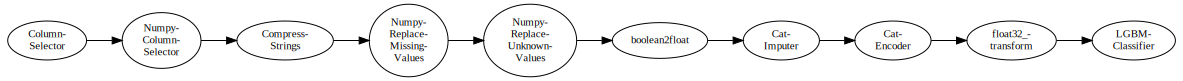

In [8]:
pipeline_model.visualize()

<a id="train_read"></a>
### Read training data

Retrieve training dataset from AutoAI experiment as pandas DataFrame.

In [9]:
train_df = optimizer.get_data_connections()[0].read()
test_df = train_df.sample(n=5).drop([experiment_metadata['prediction_column']], axis=1)

<a id="test_model"></a>
### Test pipeline model locally
You can predict target value using trained AutoAI model by calling `predict()`.

In [10]:
y_pred = pipeline_model.predict(test_df.values)
print(y_pred)

[0 0 0 1 1]


<a id="refinery"></a>
## Pipeline refinery and testing (optional)

In this section you will learn how to refine and retrain the best pipeline returned by AutoAI.
It can be performed by:
 - modifying pipeline definition source code
 - using [lale](https://lale.readthedocs.io/en/latest/) library for semi-automated data science

**Note**: In order to run this section change following cells to 'code' cell.

<a id="pipeline_definition"></a>
### Pipeline definition source code
Following cell lets you experiment with pipeline definition in python, e.g. change steps parameters.

It will inject pipeline definition to the next cell.

<a id="lale_library"></a>
### Lale library

**Note**: This is only an exemplary usage of lale package. You can import more different estimators to refine downloaded pipeline model.

#### Import estimators

<a id="decomposition_definition"></a>
#### Pipeline decomposition and new definition
In this step the last stage from pipeline is removed.

<a id="new_optimizer"></a>
#### New optimizer `hyperopt` configuration and training

This section can introduce other results than the original one and it should be used
by more advanced users.

New pipeline is re-trained by passing train data to it and calling `fit` method.

Following cell performs dataset split for refined pipeline model.

<a id="scoring"></a>
## Deploy and Score

In this section you will learn how to deploy and score pipeline model as webservice using WML instance.

<a id="wml_credentials"></a>
### Connection to WML
Authenticate the Watson Machine Learning service on IBM Cloud.

**Tip**: Your Cloud API key can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

**Note:** You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` in the following cell.

In [11]:
api_key = "PUT_YOUR_API_KEY_HERE"

wml_credentials = {
  "apikey": api_key,
  "url": experiment_metadata["deployment_url"]
}

<a id="deployment"></a>

### Create deployment
 **Action**: If you want to deploy refined pipeline please change the `pipeline_name` to
`new_pipeline`.
If you prefer you can also change the `deployment_name`.

 **Action**: To perform deployment please specify `target_space_id`.


In [12]:
target_space_id = "PUT_YOUR_TARGET_SPACE_ID_HERE"

from ibm_watson_machine_learning.deployment import WebService
service = WebService(source_wml_credentials=wml_credentials,
                     target_wml_credentials=wml_credentials,
                     source_project_id=experiment_metadata['project_id'],
                     target_space_id=target_space_id)
service.create(
model=pipeline_name,
metadata=experiment_metadata,
deployment_name=f'{pipeline_name}_webservice'
)

WMLClientError: Error during getting IAM Token.
Reason: <Response [400]>

Deployment object could be printed to show basic information:

In [13]:
print(service)

NameError: name 'service' is not defined

To be able to show all available information about deployment use `.get_params()` method:

In [14]:
service.get_params()

NameError: name 'service' is not defined

<a id="online_scoring"></a>
### Score webservice
You can make scoring request by calling `score()` on deployed pipeline.

In [ ]:
predictions = service.score(payload=test_df)
predictions

If you want to work with the webservice in external Python application you can retrieve the service object by:
 - initialize service by:
```
 service = WebService(target_wml_credentials=wml_credentials,
                      target_space_id=target_space_id)
```
 - get deployment_id by `service.list()` method
 - get webservice object by `service.get('deployment_id')` method

After that you can call `service.score()` method.

<a id="delete_deployment"></a>
### Delete deployment

You can delete an existing deployment by calling `service.delete()`.

<a id="authors"></a>
### Authors

Licensed Materials - Copyright © 2020 IBM. This notebook and its source code are released under the terms of the ILAN License.
Use, duplication disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

**Note:** The auto-generated notebooks are subject to the International License Agreement for Non-Warranted Programs  
(or equivalent) and License Information document for Watson Studio Auto-generated Notebook (License Terms),  
such agreements located in the link below. Specifically, the Source Components and Sample Materials clause  
included in the License Information document for Watson Studio Auto-generated Notebook applies to the auto-generated notebooks.  

By downloading, copying, accessing, or otherwise using the materials, you agree to the <a href="http://www14.software.ibm.com/cgi-bin/weblap/lap.pl?li_formnum=L-AMCU-BHU2B7&title=IBM%20Watson%20Studio%20Auto-generated%20Notebook%20V2.1">License Terms</a>  

___